Initialization

In [1]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import IPython.display as display
from scipy import ndimage
import cv2

from filters import lowpass, highpass
from multiprocess_fns import get_img, remove_small_obj, pmap, unsharp, run_avg, run_grey_dilation
from globals import data_dir, R, C

images = []
data_dirs = []

for dirname in os.listdir(data_dir):
        if dirname.startswith('LuoJia1'):
            data_dirs.append(dirname)

data_dirs.sort()

# used_data_dirs = np.random.choice(data_dirs, 6, replace=False)

used_data_dirs = []
for (i, img) in enumerate(data_dirs):
    if i % 10 == 5:
        used_data_dirs.append(img)
        if len(used_data_dirs) == 12:
            break

images = pmap(get_img, used_data_dirs)

In [2]:
def show_img(out_img):
    display.display(Image.fromarray(out_img).convert('RGB'))
    # pass

def show_imgs(imgs, columns=6, rows=None, w=24, h=None, resize=500):
    if not rows:
        rows = len(imgs)//columns
    if not h:
        h = len(imgs)//columns * 4
    fig = plt.figure(figsize=(w, h))
    idx = 0
    for i in range(1, columns * rows + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(Image.fromarray(imgs[idx]).resize((resize, resize)))
        idx += 1
    plt.show()
    # pass

Load an image

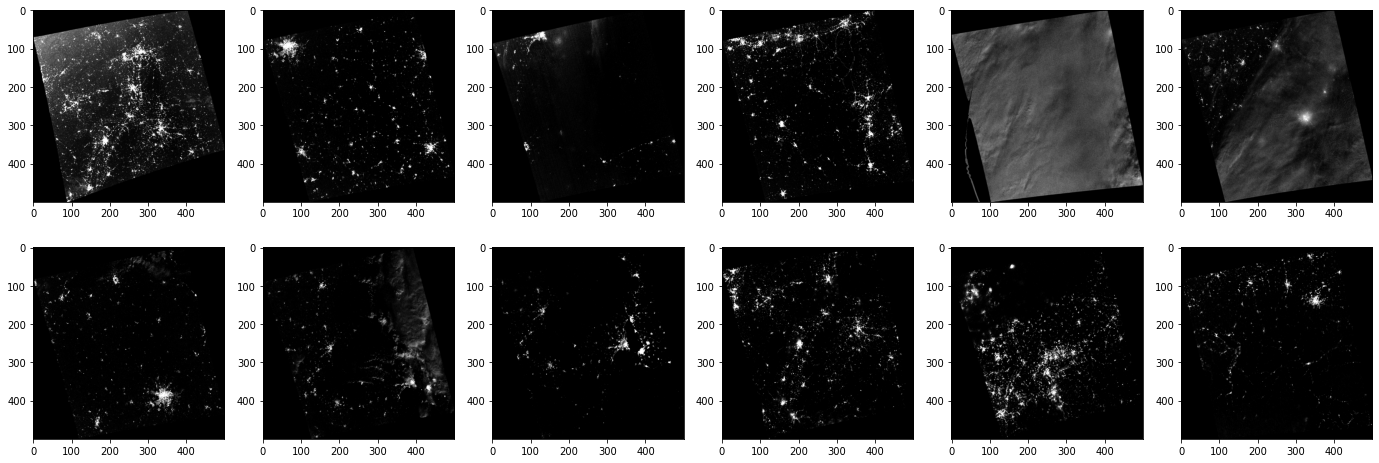

In [3]:
imgs = np.asarray(images)
show_imgs(imgs * 5)

Apply unsharp mask, streetlights are sharpened and cloud remains

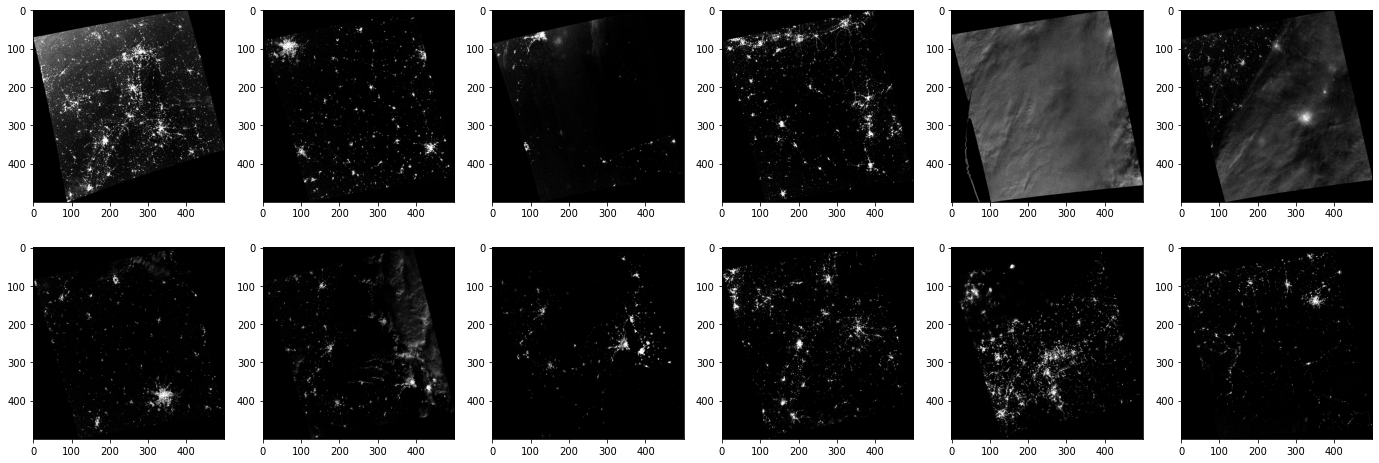

In [4]:
out_imgs = np.asarray(pmap(unsharp, imgs))
show_imgs(out_imgs * 5)

Remove bright light, generate proto cloud mask

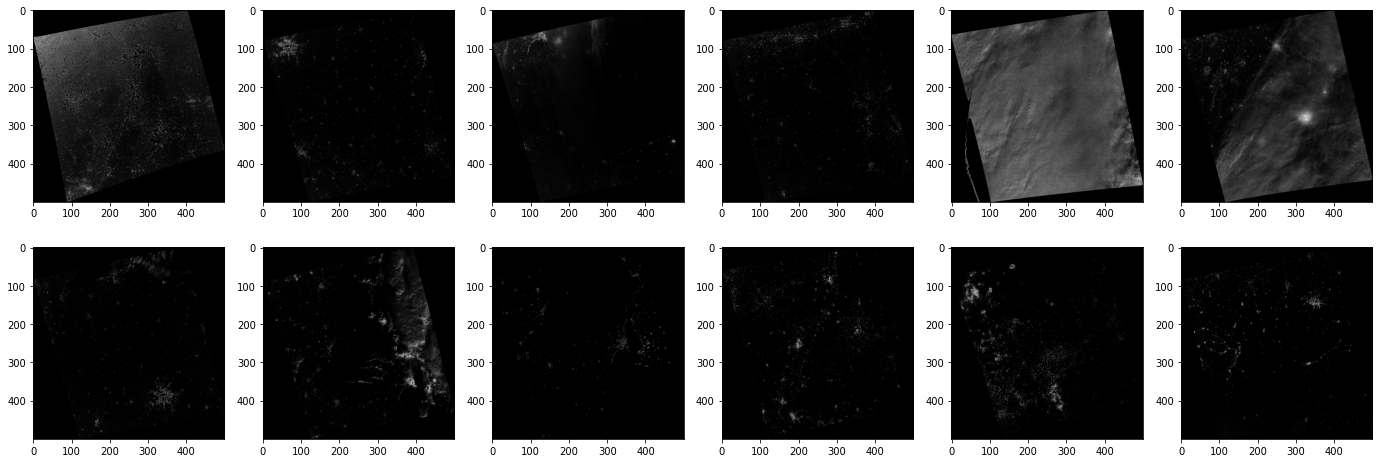

In [5]:
out_imgs = lowpass(out_imgs, 70)
show_imgs(out_imgs * 5)

Filter out dimmer streetlights by averaging.
Kernel size should be odd

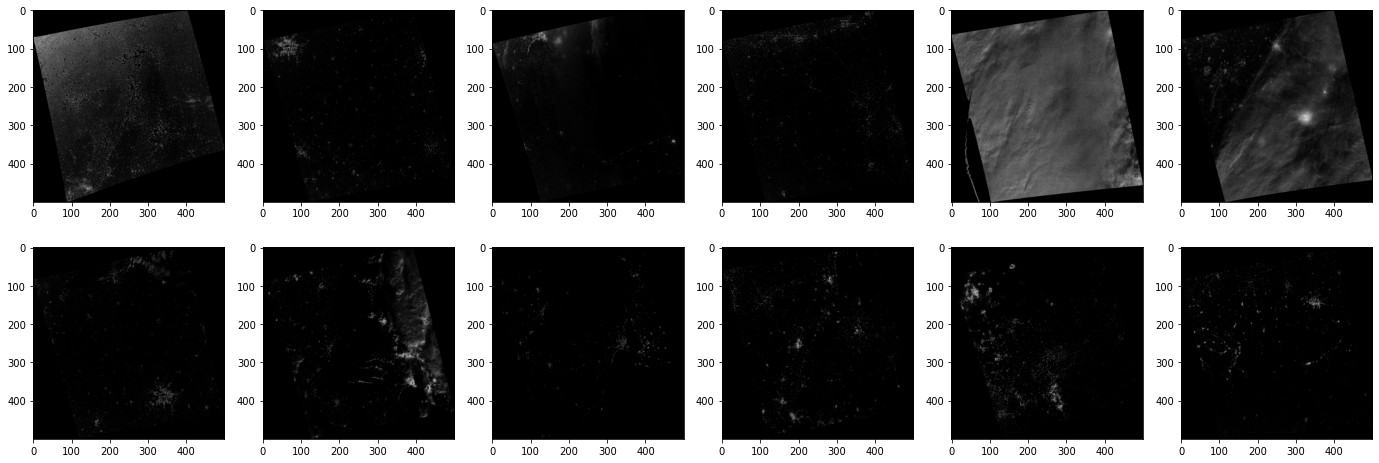

In [6]:
out_imgs = np.asarray(pmap(run_avg, out_imgs))
show_imgs(out_imgs * 5)

Remove noise using highpass, then convert to binary image

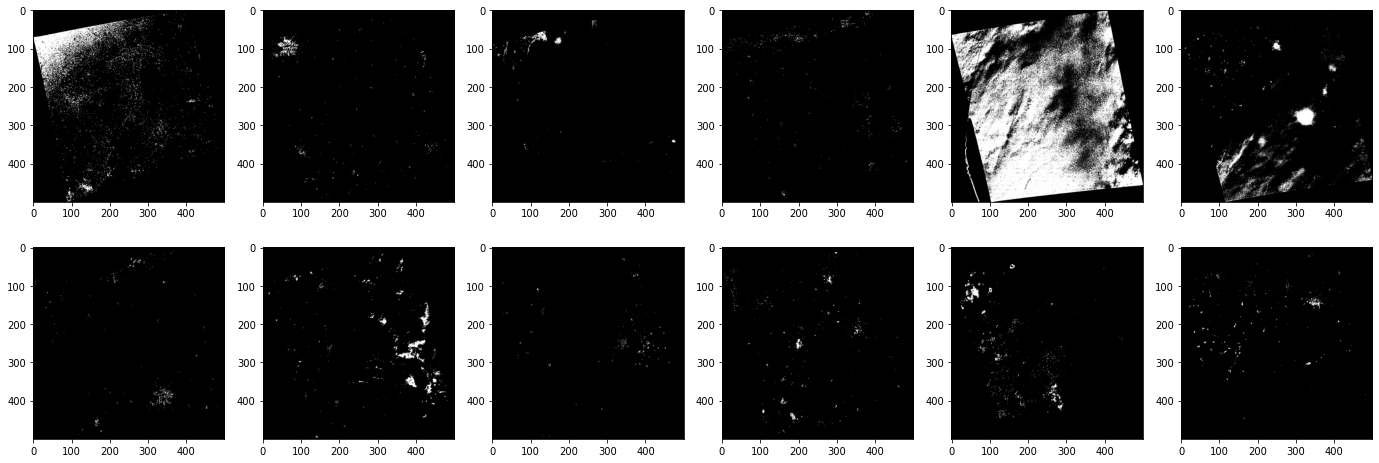

In [7]:
out_imgs = highpass(out_imgs, 14)
out_imgs[out_imgs > 0] = 1
show_imgs(out_imgs * 255)
out_imgs = out_imgs.astype(np.uint8)

Remove smaller areas. They are mostly noise

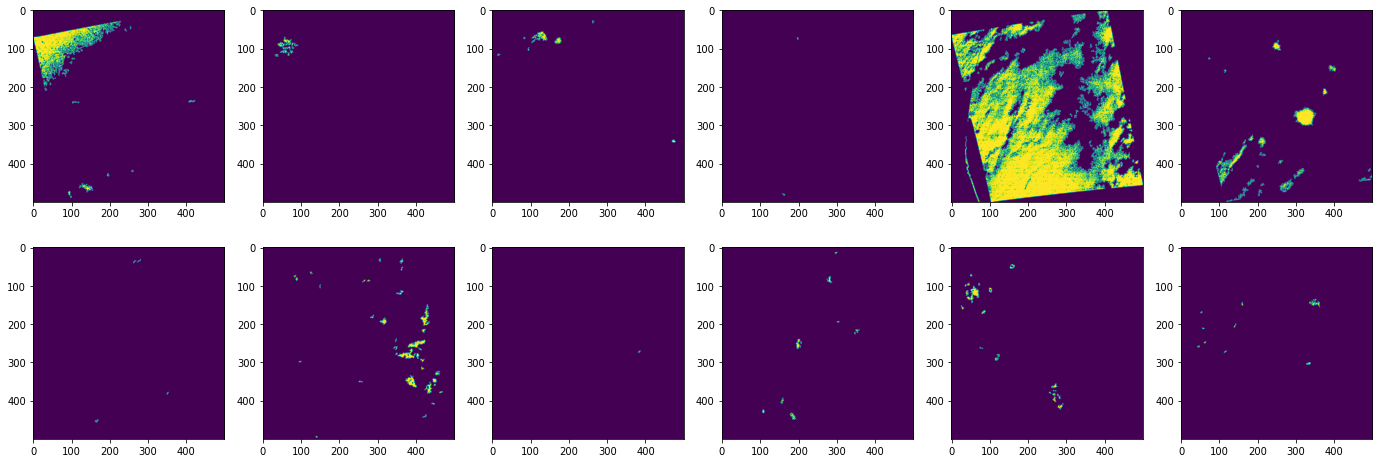

In [8]:
out_imgs = np.asarray(pmap(remove_small_obj, out_imgs), dtype=np.uint8)
show_imgs(out_imgs * 255)

Try to make shape of cloud chunks more regular

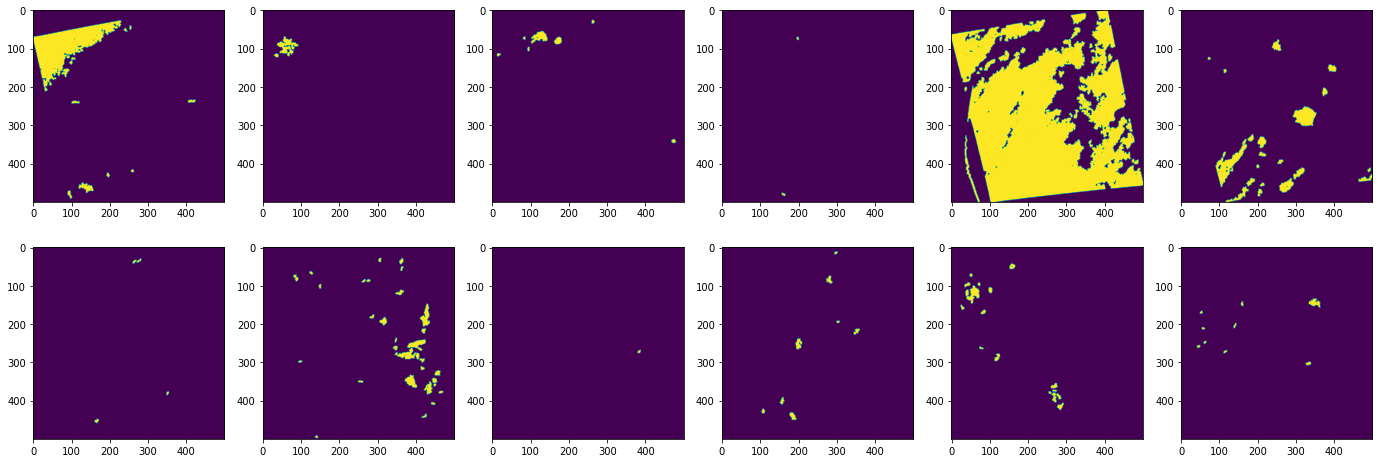

In [9]:
out_imgs = np.asarray(pmap(run_grey_dilation, out_imgs), dtype=np.uint8)
show_imgs(out_imgs * 255)

Fill holes inside cloud chunk

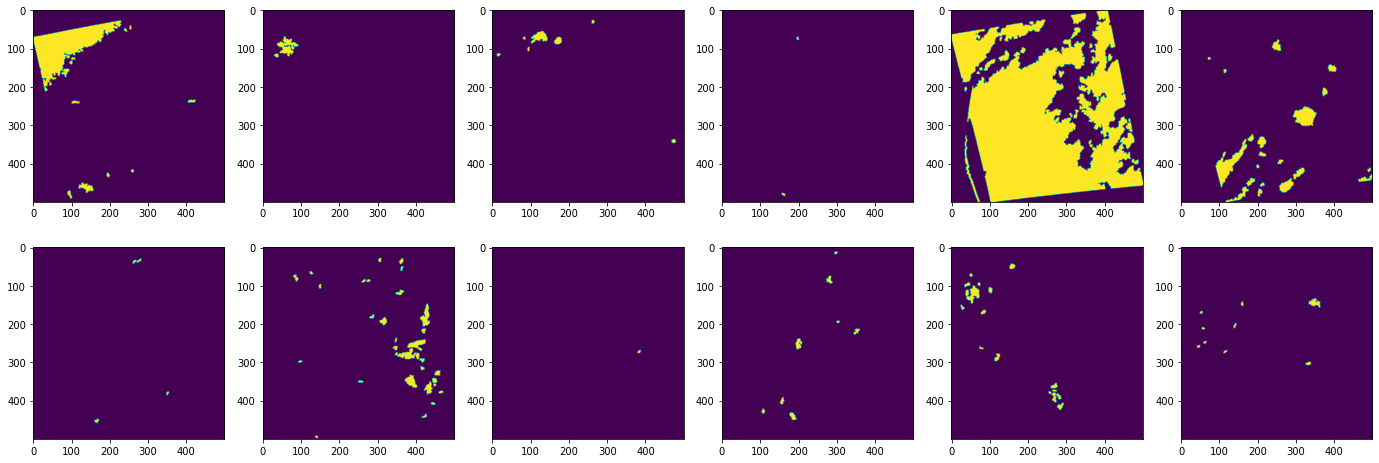

In [10]:
out_imgs = np.asarray(pmap(ndimage.morphology.binary_fill_holes, out_imgs), dtype=np.uint8)
show_imgs(out_imgs * 255)

Adding an overlay cloud mask to original image

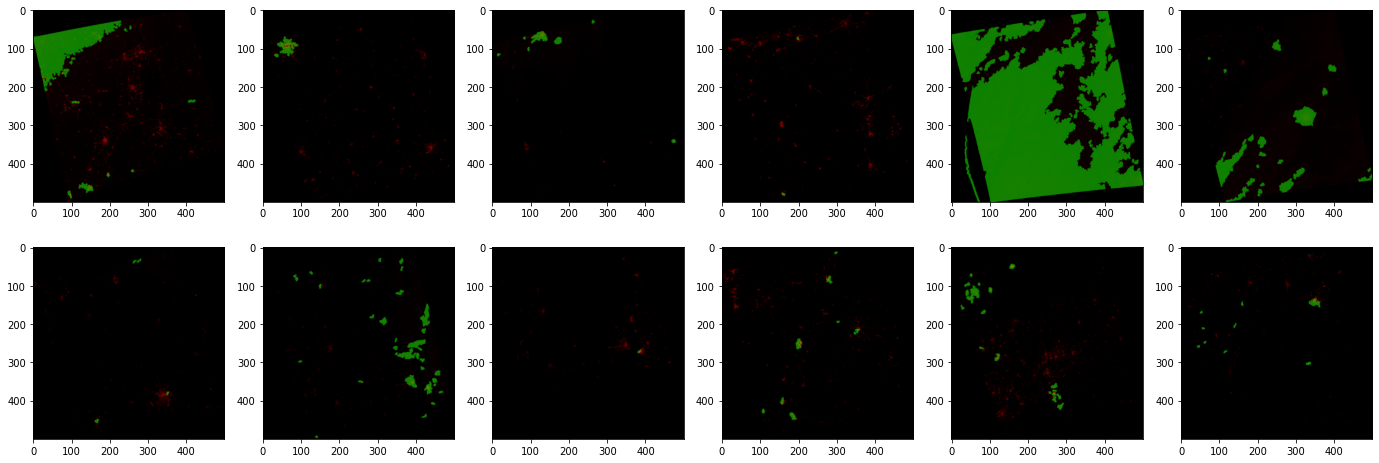

In [11]:
out_imgs_rgb = []
for (img, out_img) in zip(images, out_imgs):
    out_img_rgb = np.dstack((np.uint8(np.round(img)), out_img * 128, np.zeros((R, C), dtype=np.uint8)))
    out_imgs_rgb.append(out_img_rgb)

show_imgs(out_imgs_rgb)

Show full res image for fun

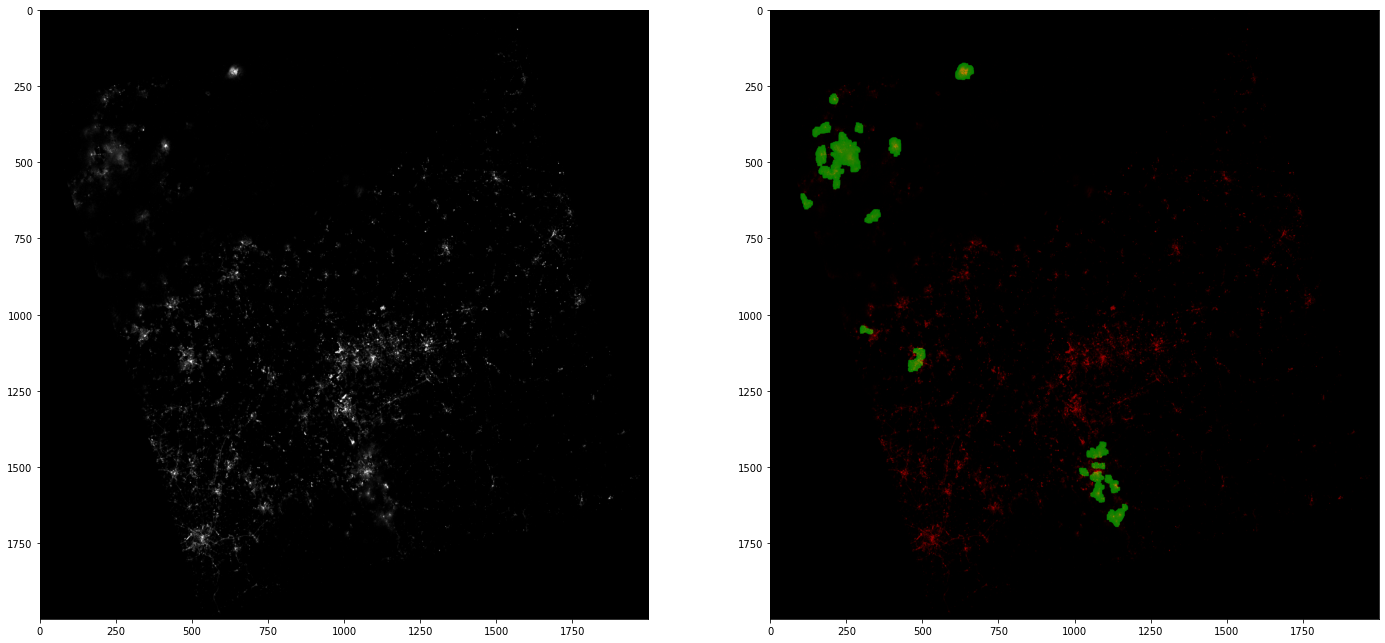

In [12]:
i = 10
show_imgs([images[i], out_imgs_rgb[i]], columns=2, rows=1, w=24, h=14, resize=2000)

In [13]:
# for (data_dir, img, out_img_rgb) in zip(used_data_dirs, images, out_imgs_rgb):
#     Image.fromarray(img).convert('RGB').save('./data_png/{}.png'.format(data_dir))
#     Image.fromarray(out_img_rgb).convert('RGB').save('./data_out/{}.png'.format(data_dir))